# Simple Random Sampling: Not So Simple

Random sampling is one of the most fundamental tools in Statistics.

Used for:

+ Surveys and extrapolation
    - Opinion surveys and polls
    - Census (for some purposes) and Current Population Survey
    - Environmental statistics
    - Litigation, including class actions, discrimination, ...
+ Experiments
    - Medicine / clinical trials
    - Agriculture
    - Marketing
    - Product development
+ Quality control and auditing
    - Process control
    - Financial auditing
    - Healthcare auditing
    - Election auditing
+ Sampling and resampling methods
    - Bootstrap
    - Permutation tests
    - MCMC

and on and on.

_Simple random sampling_ refers to drawing $k \le n$ items from a population of $n$ items, in such a way that
each of the $n \choose k$ subsets of size $k$ is equally likely.

Many standard statistical methods assume the sample is drawn in this way, or allocated between treatment and control in this way (e.g., $k$ of $n$ subjects are assigned to treatment, and the remaining $n-k$ to control).


This notebook examines common strategies for drawing pseudo-random samples of size $k$ from a population of size $n$. 

It has a brief disussion of pseudo-random number generators (PRNGs) and of algorithms used to select pseudo-random samples using PRNGs.

Among other things, it finds bounds on the number of samples that can be generated using a variety of PRNGs, for a number of algorithms that use PRNs to generate samples:

+ a common algorithm that involves assigning a PRN to each of the $n$ elements, then taking those elements assigned the smallest $k$ numbers to be the sample (`PIKK` for "permute and keep $k$")
+ algorithm `R`, a streamable algorithm that also uses at least one PRN per element of the population, but avoids the sort
+ algorithm `Random-Sample` on p. 130 of [Cormen et al. (2009)](https://mitpress.mit.edu/books/introduction-algorithms), which uses only $k$ random integers
+ a hypothetical sampling algorithm that uses an optimal coding of samples to turn strings of $\log_2{n \choose k}$ bits into samples of size $k$

It also considers how that affects the bias and uncertainty of estimates based on such pseudo-random samples rather than on actual simple random samples.

PRNGs considered include [linear congruential generators](https://en.wikipedia.org/wiki/Linear_congruential_generator) (LCGs, including [RANDU](https://en.wikipedia.org/wiki/RANDU)), and the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). The behavior of the [middle square method](https://en.wikipedia.org/wiki/Middle-square_method) is worse. 
There is some discussion of using cryptographic hash functions to generate PRNs.

[Kellie Ottoboni](http://www.stat.berkeley.edu/~kellieotto/), [Ronald L. Rivest](http://people.csail.mit.edu/rivest/) and [Philip B. Stark](www.stat.berkeley.edu/~stark)



## References

1. Cormen, T.H., C.E. Leiserson, R.L. Rivest and C. Stein, 2009. _Introduction to Algorithms, 3rd edition_, MIT Press.
1. Fishman, G.S., and L.R. Moore, 1981. In Search of Correlation in Multiplicative Congruential Generators with Modulus 2\*\*31-1, _Computer Science and Statistics: Proceedings of the 13 Symposium on the Interface_, William F. Eddy, ed., Springer Verlag, New York.
1. Knuth, D., 1997 _The Art of Computer Programming, V.II: Seminumerical methods_, 3rd edition, Addison-Wesley, Boston.
1. L'Ecuyer, P. and R. Simard, 2007. TestU01: A C Library for Empirical Testing of Random Number Generators, _ACM Trans. Math. Softw._, _33_, http://doi.acm.org/10.1145/1268776.1268777
1. Marsaglia, G., 1968. Random Numbers Fall Mainly in the Planes, _PNAS_, _61_, 25&ndash;28.
1. Marsaglia, G., 2003. Xorshift RNGs. _Journal of Statistical Software_, _8_, 1&ndash;6.
1. Matsumoto, M., and T. Nishimura, 1998. 8). Mersenne twister: a 623-dimensionally equidistributed uniform pseudo-random number generator, _ACM Transactions on Modeling and Computer Simulation_, _8_, 3&ndash;30. doi:10.1145/272991.272995
1. NIST Computer Security Division, _Random Number Generation_ http://csrc.nist.gov/groups/ST/toolkit/rng/
1. O'Neill, M.E., 2015. PCG: A Family of Simple Fast Space-Efficient Statistically Good Algorithms for Random Number Generation, submitted to _ACM Transactions on Mathematical Software_. http://www.pcg-random.org/pdf/toms-oneill-pcg-family-v1.02.pdf
1. http://www.pcg-random.org/
1. Shannon, C.E., 1948. A Mathematical Theory of Communication, _Bell System Technical Journal, 27_, 379&ndash;423, 623&ndash;656. 
1. Vitter, J.S., 1985. Random Sampling with a Reservoir, _ACM Transactions on Mathematical Software, 11_, 37&ndash;57.
1. Wikipedia articles, including https://en.wikipedia.org/wiki/Mersenne_Twister, https://en.wikipedia.org/wiki/Linear_congruential_generator, https://en.wikipedia.org/wiki/Comparison_of_hardware_random_number_generators, https://en.wikipedia.org/wiki/Pseudorandom_number_generator, https://en.wikipedia.org/wiki/List_of_random_number_generators 

Highly encourage you to look at the customer reviews of _A Million Random Digits with 100,000 Normal Deviates_ on Amazon.com 

https://www.amazon.com/Million-Random-Digits-Normal-Deviates/dp/0833030477

> Such a terrific reference work! But with so many terrific random digits, it's a shame they didn't sort them, to make it easier to find the one you're looking for.

> While the printed version is good, I would have expected the publisher to have an audiobook version as well. 

> The book is a promising reference concept, but the execution is somewhat sloppy. Whatever generator they used was not fully tested. The bulk of each page seems random enough. However at the lower left and lower right of alternate pages, the number is found to increment directly.

> If you like this book, I highly recommend that you read it in the original binary. As with most translations, conversion from binary to decimal frequently causes a loss of information and, unfortunately, it's the most significant digits that are lost in the conversion.

> At first, I was overjoyed when I received my copy of this book. However, when an enemy in my department showed me HER copy, I found that they were the OPPOSITE of random - they were IDENTICAL.

In [1]:
%matplotlib inline
from __future__ import division
import math
import numpy as np
import scipy as sp
from scipy.misc import comb, factorial
from scipy.optimize import brentq
from scipy.stats import chisquare, norm
import scipy.integrate
from random import Random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Pigeon-hole principle

If you put $N>n$ pigeons in $n$ pigeonholes, then at least one
pigeonhole must contain more than one pigeon.

## Corollary
At most $n$ pigeons can be put in $n$ pigeonholes if at most
one pigeon is put in each hole.

## Some pigeon coops & flocks

| Expression     | full      |  scientific notation | 
|:---------------:|----------:|----------:|
|$2^{32}$        | 4,294,967,296 | 4.29e9 |
|$2^{64}$        |   18,446,744,073,709,551,616 | 1.84e19|
|$2^{128}$       |            | 3.40e38 |
|$2^{32 \times 624}$ | | 9.27e6010|
|$13!$      |                           6,227,020,800 | 6.23e9|
|$21!$      |     51,090,942,171,709,440,000 | 5.11e19|                        
|$35!$      |                                    | 1.03e40|
|$2084!$     |                                                 | 3.73e6013 |
|${50 \choose 10}$   |        10,272,278,170 | 1.03e10|
|${100 \choose 10}$ | 17,310,309,456,440 | 1.73e13|
|${500 \choose 10}$ |         |     2.4581e20 |
|$\frac{2^{32}}{{50 \choose 10}}$   | 0.418 | |
|$\frac{2^{64}}{{500 \choose 10}}$ | 0.075 | |


What if the number of samples or the number of permutations does not divide the number of states?

## Outline:

+ Impossibility bounds from pidgeon-hole principle, assuming perfect PRNG
+ Implications for $L_1$ distance bounds
+ Some bad algorithms for sampling, assuming perfect PRNG
    - drawing an integer uniform on ${1, \ldots, m}$
    - simple random sampling
+ A review of PRNGs
+ Empirical results for bias of the sample mean
+ What should we do?

## $L_1$ bounds

Suppose ${\mathbb P}_0$ and ${\mathbb P}_1$ are probability distributions on a common measurable space. 

If there is some set $S$ for which ${\mathbb P}_0 = \epsilon$ and ${\mathbb P}_1(S) = 0$, then $\|{\mathbb P}_0 - {\mathbb P}_1 \|_1 \ge 2 \epsilon$.

It follows that there is a function $f$ with $|f| \le 1$ such that 

$${\mathbb E}_{{\mathbb P}_0}f -  {\mathbb E}_{{\mathbb P}_1}f \ge 2 \epsilon.$$

### Generating a random integer uniformly distributed on $\{1, \ldots, m\}$


#### Naive method
A standard way to generate a random integer is to start with $X \sim U[0,1)$ and define $Y \equiv 1 + \lfloor mX \rfloor$. 

In theory, that's fine. But in practice, $X$ is not really $U[0,1)$ but instead is derived by normalizing a PRN
that's uniform on $w$-bit integers. Then, unless $m$ is a power of 2, the distribution of $Y$ isn't uniform on $\{1, \ldots, m\}$. For $m < 2^w$, the ratio of the largest to smallest selection probability 
is, to first order,  $1+ m 2^{-w}$. (See, e.g., Knuth v2 3.4.1.A.)

For $m = 10^9$ and $w=32$, $1 + m 2^{-w} \approx 1.233$. That could easily matter.

For $m > 2^{w}$, at least $m-2^w$ values will have probability 0 instead of probability $1/m$. 

If $w=32$, then for $m>2^{32}=4.24e9$, some values will have probability 0. Until relatively recently, R did not support 64-bit integers.

#### More accurate method
A better way to generate a (pseudo-)random integer on $\{1, \ldots m\}$ from a (pseudo-random) $w$-bit integer in practice is as follows:

1. Set $\mu = \log_2(m-1)$.
1. Define a $w$-bit _mask_ consisting of $\mu$ bits set to 1 and $(w-\mu)$ bits set to zero.
1. Generate a random $w$-bit integer $Y$. 
1. Define $y$ to be the bitwise `and` of $Y$ and the mask.
1. If $y \le m-1$, output $x = y+1$; otherwise, return to step 3.

This is how random integers are generated in numpy by `numpy.random.randint()`.
However, `numpy.random.choice()` does something else that's biased: it finds the closest integer to $mX$.

In `R`, one would generally use the function `sample(1:m, k, replace=FALSE)` to draw pseudo-random
integers. 
It seems that `sample()` uses the faulty `1 + floor(m*X)` approach. 

<hr />
# Random sampling

A _simple random sample of size $k$ from a population of size $n$_ is a sample drawn in such a way that each of the ${n \choose k}$ possible subsets of size $k$ is equally likely.

Given a good source of randomness, there are many ways to operationalize this definition to draw simple random samples.

One basic approach is like shuffling a deck of $n$ cards, then dealing the top $k$: permute the population at random, then take the first $k$ elements of the permutation to be the sample.

There are a number of standard ways to generate a random permutation&mdash;i.e., to shuffle the deck.

### Algorithm `PIKK` (permute indices and keep $k$)

For instance, if we had a way to generate independent, identically distributed (iid) $U[0,1]$ random numbers, we could do it as follows:

**Algorithm `PIKK`**

+ assign iid $U[0,1]$ numbers to the $n$ elements of the population
+ the sample consists of the $k$ items assigned the smallest random numbers (break ties randomly)

+ amounts to generating a random permutation of the population, then taking first $k$.
+ if the numbers really are iid, every permutation is equally likely, and it follows that the first $k$ are an SRS
+ requires $n$ random numbers (and sorting)

In [2]:
# LCG; defaults to RANDU, a particularly bad choice
class lcgRandom: # defaults to RANDU: BEWARE!
    def __init__(self, seed=1234567890, A=0, B=65539, M = 2**31): 
        self.state = seed
        self.A = A
        self.B = B
        self.M = M
        
    def getState(self):
        return self.state, self.A, self.B, self.M
    
    def setState(self,seed=1234567890, A=0, B=65539, M = 2**31):
        self.state = seed
        self.A = A
        self.B = B
        self.M = M

    def nextRandom(self):
        self.state = (self.A + self.B * self.state) % self.M
        return self.state/self.M

    def random(self, size=None):  # vector of rands
        if size==None:
            return self.nextRandom()
        else: 
            return np.reshape(np.array([self.nextRandom() for i in np.arange(np.prod(size))]), size)
    
    def randint(self, low=0, high=None, size=None):  # integer between low (inclusive) and high (exclusive)
        if high==None:  # numpy.random.randint()-like behavior
            high, low = low, 0
        if size==None:
            return low + np.floor(self.nextRandom()*(high-low)) # NOT AN ACCURATE ALGORITHM! See below.
        else:
            return low + np.floor(self.random(size=size)*(high-low))
        

In [3]:
def PIKK(n,k, gen=np.random):
    try: 
        x = gen.random(n)
    except TypeError:
        x = np.array([gen.random() for i in np.arange(n)])
    return set(np.argsort(x)[0:k])

There are more efficient ways to generate a random permutation than assigning a number to each element and sorting, for instance the "Fisher-Yates shuffle" or "Knuth shuffle" (Knuth attributes it to Durstenfeld). 

**Algorithm Fisher-Yates-Knuth-Durstenfeld `shuffle` (backwards version)**

    for i=1, ..., n-1:
        J <- random integer uniformly distributed on {i, ..., n}
        (a[J], a[i]) <- (a[i], a[J])
        
This requires the ability to generate independent random integers on various ranges. Doesn't require sorting.

There's a version suitable for streaming, i.e., generating a random permutation of a list that has an (initially) unknown number $n$ of elements:

**Algorithm Fisher-Yates-Knuth-Durstenfeld `shuffle` (streaming version)**

    i <- 0
    a = []
    while there are records left:
        i <- i+1
        J <- random integer uniformly distributed on {1, ..., i}
        if J < i:
            a[i] <- a[J]
            a[J] <- next record
        else:
            a[i] <- next record

Again, need to be able to generate independent uniformly distributed random integers.

In [4]:
def fykd(a, gen=np.random):
    for i in range(len(a)-2):
        J = gen.randint(i,len(a))
        a[i], a[J] = a[J], a[i]
    return(a)

print fykd(range(10))

[9, 0, 3, 5, 6, 4, 7, 2, 8, 1]


### Proof that the streaming Fisher-Yates-Knuth-Durstenfeld algorithm works

Induction: 

For $i=1$, obvious.

At stage $i$, suppose all $i!$ permutations are equally likely. For each such permutation, there are
$i+1$ distinct, equally likely permutations at stage $i+1$, resulting from swapping the $i+1$st item with one
of the first $i$, or putting it in position $i+1$. These possibilities are mutually exclusive of
the permutations attainable from a different permutation of the first $i$ items.

Thus, this enumerates all $(i+1)i! = (i+1)!$ permutations of $(i+1)$ items, and they are equally likely. &#x25A0;

## A good way to get a bad shuffle

Sort using a "random" comparison function, e.g.,

    def RandomSort(a,b):
        return (0.5 - np.random.random())

But this fails the basic properties of an ordering, e.g., transitivity, reflexiveness, etc. Doesn't produce random permutation. Output also depends on sorting algorithm. 

#### The right way, the wrong way, and the Microsoft way.
Notoriously used by Microsoft to offer a selection of browsers in the EU. Resulted in IE being 5th of 5 about half the time in IE and about 26% of the time in Chrome, but only 6% of the time in Safari (4th about 40% of the time). 

See, e.g., http://www.computerworld.com/article/2520190/web-apps/microsoft-s-eu-ballot-fails-to-randomize-browser-order.html


### Cormen et al. (2009) Algorithm `Random_Sample`

+ recursive algorithm
+ requires only $k$ random numbers (integers)
+ does not require sorting

In [5]:
def Random_Sample(n, k, gen=np.random):  # from Cormen et al.
    if k==0:
        return set()
    else:
        S = Random_Sample(n-1, k-1)
        i = gen.randint(1,n+1) 
        if i in S:
            S = S.union([n])
        else:
            S = S.union([i])
    return S

Random_Sample(100,5)

{17, 40, 60, 64, 93}

**Proof.** Recursion.

## Reservoir algorithms 

The previous algorithms require $n$ to be known.
There are _reservoir_ algorithms that do not.
Moreover, the algorithms are suitable for streaming (aka _online_) use: items are examined
sequentially and either enter into the reservoir, or, if not, are never revisited.

## Algorithm `R`, Waterman (per Knuth, 1997)
+ Put first $k$ items into the _reservoir_
+ when item $k+j$ is examined, either skip it (with probability $j/(k+j)$) or swap for a uniformly selected item in the reservoir (with probability $k/(k+j)$)
+ naive version requires generating at most $n-k$ random numbers
+ closely related to FYKD shuffle

In [6]:
def R(n,k):  # Waterman's algorithm R
    S = range(1, k+1)  # fill the reservoir
    for t in range(k+1,n+1):
        i = np.random.randint(1,t+1)
        if i <= k:
            S[i-1] = t
    return set(S)

R(100,5)

{43, 50, 62, 77, 88}

Like `Random-Sample`, the proof that algorithm `R` generates an SRS uses the ability to generate independent random integers, uniformly distributed on $\{1, \ldots, m \}$.

## Algorithm Z, Vitter (1985)

Much more efficient than `R`, using random skips. Works in time essentially linear in $k$. 

Note: Vitter proposes using the (inaccurate) $J = \lfloor mU \rfloor$ to generate a random integer between $0$ and $m$ in both algorithm `R` and algorithm `Z`. The issue is pervasive!

## Pseudo-random number generators (PRNGs)

Most computers lack the hardware needed to generate truly random numbers. (But see, e.g., https://en.wikipedia.org/wiki/Comparison_of_hardware_random_number_generators.  As of 23 June 2016, www.random.org claims to have produced $1.30 \times 10^9$ random bits. That's a little less than 10 full periods of a PRNG with 32-bit output and 32-bit state.)

Instead, they use algorithms called _pseudo-random number generators_ (PRNGs) to generate deterministic sequences from an initial "seed," which generally can be set by the user, for instance to an externally generated random value.

Depending on the quality of the PRNG, the sequences behave more or less like sequences of random numbers.

Each time a number is generated, the PRNG's "state" changes.

Must consider fitness for use of PRNGs. What's "good enough?"

Different requirements for statistics with small data, simulations, statistics with big data, and cryptography.

## Properties of PRNGs

+ dimension of output
    - commonly 32 bits, but some have more
    
+ number of states
    - dimension of state space in bits
    - sometimes state = output, but better generators generally have output = f(state)

+ period
    - maximum over initial states of the number of states visited before repeating
    - period &le; number of states
    - if state has $s$ bits, period $\le 2^s$
    - for some PRNGs, period is much less than number of states
    - for some seeds for some PRNGs, number of states visited is much less than period
    
+ $k$-distribution
    - suppose $\{X_i\}$ is sequence of $P$ $w$-bit integers
    - define $t_v(X_i)$ to be the first $v$ bits of $X_i$
    - $\{X_i\}$ is $k$-distributed to $v$-bit accuracy if each of the $2^{kv}-1$ possible nonzero $kv$-bit vectors occurs equally often among the $P$ $kv$-bit vectors
$$ (t_v(X_i),\,t_v(X_{i+1}), \ldots ,t_v(X_{i+k-1}))\quad (0\le i<P),$$
and the zero vector occurs once less often.
    - amounts to a form of uniformity in $k$-dimensional space, over an entire cycle
    - does not measure dependence or other "serial" properties

+ sensitivity to initial state; burn-in
    - many PRNGs don't do well if the seed has too many zeros
    - some require many iterations before output behaves well
    - for some seeds, some PRNGs repeat very quickly

## Some PRNGs

### Middle Square

Dates to Franciscan friar ca. 1240 (per [Wikipedia](https://en.wikipedia.org/wiki/Middle-square_method)); reinvented by von Neumann ca. 1949.

Take $n$-digit number, square it, use middle $n$ digits as the "random" and the new seed.

E.g., for $n=4$, take $X_0 = 1234$.

$1234^2 = 1522756$, so $X_1 = 2275$.

$2275^2 = 5175625$, so $X_2 = 7562$.

+ $10^n$ possible states, but not all attainable from a given seed
+ period at most $8^n$, but can be very short. E.g., for $n=4$,
    - 0000, 0100, 2500, 3792, & 7600 repeat forever
    - 0540 &rightarrow; 2916 &rightarrow; 5030 &rightarrow; 3009 &rightarrow; 0540


### Linear Congruential Generators (LCGs) 

$$ X_{n+1} = (aX_n +c)\mod m.$$

LCG period is at most $m$.

#### Hull-Dobell Theorem: the period of an LCG is $m$ for all seeds $X_0$ iff

+ $m$ and $c$ are relatively prime
+ $a-1$  is divisible by all prime factors of $m$
+ $a-1$  is divisible by 4 if $m$ is divisible by 4

#### Marsaglia (PNAS, 1968): Random Numbers Fall Mainly in the Planes
Multiplicative congruential generators ($c=0$), Lehmer (1949).

<img src="./marsaglia68.png" />

### RANDU

RANDU is a particularly bad [linear congruential generator](https://en.wikipedia.org/wiki/Linear_congruential_generator) promulgated in the 1960s and widely copied.

RANDU is given by the recursion

$$ X_{j+1} = 65539 X_j\mod 2^{31}.$$

It has a short period ($2^{29}$), all its outputs are odd integers. It fails the spectral test.

Triples of values from RANDU fall on 15 planes in 3-dimensional space, as shown below.

In [7]:
# generate triples using RANDU
reps = int(10**5)
randu = lcgRandom(12345)
xs = np.transpose(randu.random(size=(reps,3)))

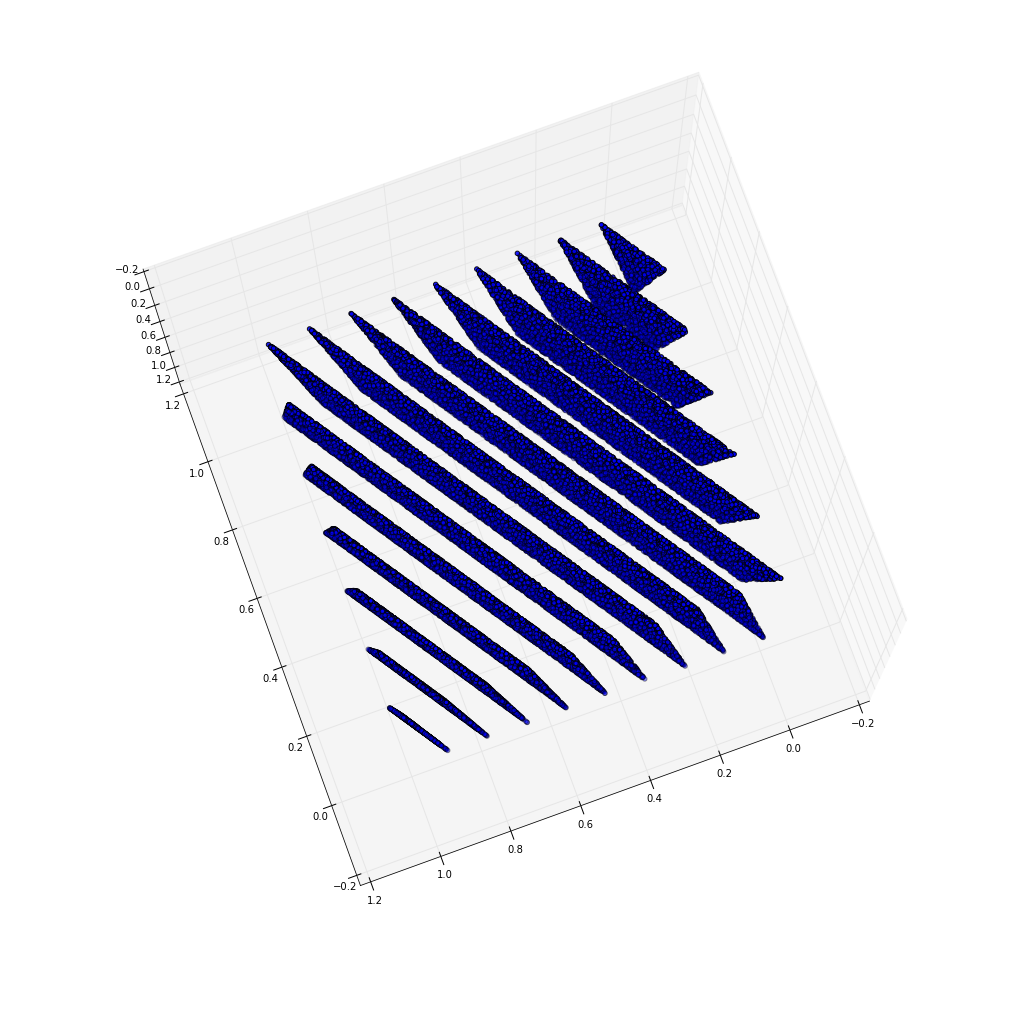

In [45]:
# plot the triples as points in R^3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[0],xs[1], xs[2])

plt.rcParams['figure.figsize'] = (18.0, 18.0) 

ax.view_init(-100,110)

plt.show()

### Wichmann-Hill (1982)

Sum of 3 LCGs. Period is 6,953,607,871,644. 

    def WH(s1, s2, s3):
        s1 = (171 * s1) % 30269
        s2 = (172 * s2) % 30307
        s3 = (170 * s3) % 30323
        r = (s1/30269 + s2/30307 + s3/30323) %  1
        return [r, s1, s2, s3]

#### The right way, the wrong way, and the Microsoft way.
WH generally not considered adequate for statistics, but was (nominally) the PRNG in Excel for several
generations. Excel did not allow the seed to be set, so analyses were not reproducible.

Moreover, WH in Excel had an implementation bug that persisted for several generations (occasionally gave
a negative number; since seed couldn't be set, could not replicate!). See
McCullough, B.D., 2008. Microsoft Excel’s ‘Not The Wichmann–Hill’ random number generators
_Computational Statistics & Data Analysis_, _52_, 4587&ndash;4593
doi:10.1016/j.csda.2008.03.006

### Mersenne Twister (MT)  Matsumoto & Nishimura (1997)

+ example of "twisted generalized feedback shift register"
+ period $2^{19937}-1$, a Mersenne Prime
+ $k$-distributed to 32-bit accuracy for all $k \in \{1, \ldots, 623\}$. 
+ passes DIEHARD and most of TestU01 (see below)
+ standard in many packages:
    - GNU Octave, Maple, MATLAB, Mathematica, Python, R, Stata
    - Apache, CMU Common Lisp, Embeddable Common Lisp, Free Pascal, GLib, PHP, GAUSS, IDL, Julia, Ruby, SageMath, Steel Bank Common Lisp, Scilab, Stata, GNU Scientific Library, GNU Multiple Precision Arithmetic Library, Microsoft Visual C++.
    - SPSS and SAS offer MT, as does C++ (v11 and up)
+ generally considered adequate for statistics (but not for cryptography); however, will trouble that in this work, esp. for "big data"
+ usual implementation has 624-dimensional state space, but TinyMT uses only 127 bits
+ seeding complicated, since state is an array
+ can take a while to "burn in," especially for seeds with many zeros
+ output for close seed states can be close
+ 2002 update improves seeding
+ completely predictable from 624 successive outputs
+ problems discovered in 2007 (see TestU01, below)

In [9]:
# Python implementation of MT19937 from Wikipedia 
# https://en.wikipedia.org/wiki/Mersenne_Twister#Python_implementation

def _int32(x):
    # Get the 32 least significant bits.
    return int(0xFFFFFFFF & x)

class MT19937:

    def __init__(self, seed):
        # Initialize the index to 0
        self.index = 624
        self.mt = [0] * 624
        self.mt[0] = seed  # Initialize the initial state to the seed
        for i in range(1, 624):
            self.mt[i] = _int32(
                1812433253 * (self.mt[i - 1] ^ self.mt[i - 1] >> 30) + i)

    def extract_number(self):
        if self.index >= 624:
            self.twist()

        y = self.mt[self.index]

        # Right shift by 11 bits
        y = y ^ y >> 11
        # Shift y left by 7 and take the bitwise and of 2636928640
        y = y ^ y << 7 & 2636928640
        # Shift y left by 15 and take the bitwise and of y and 4022730752
        y = y ^ y << 15 & 4022730752
        # Right shift by 18 bits
        y = y ^ y >> 18

        self.index = self.index + 1

        return _int32(y)

    def twist(self):
        for i in range(624):
            # Get the most significant bit and add it to the less significant
            # bits of the next number
            y = _int32((self.mt[i] & 0x80000000) +
                       (self.mt[(i + 1) % 624] & 0x7fffffff))
            self.mt[i] = self.mt[(i + 397) % 624] ^ y >> 1

            if y % 2 != 0:
                self.mt[i] = self.mt[i] ^ 0x9908b0df
        self.index = 0

### xorshift family

Originated by Marsaglia, 2003.

Vigna, S., 2014. Further scramblings of Marsaglia's xorshift generators. https://arxiv.org/abs/1404.0390

128-bit xorshift+  Implemented in Python package randomstate https://pypi.python.org/pypi/randomstate/1.10.1

    uint64_t s[2];

    uint64_t xorshift128plus(void) {
	    uint64_t x = s[0];
	    uint64_t const y = s[1];
	    s[0] = y;
	    x ^= x << 23; // a
	    s[1] = x ^ y ^ (x >> 17) ^ (y >> 26); // b, c
	    return s[1] + y;
    }
    
    
1024-bit xorshift+

    uint64_t s[16];
    int p;
    
    uint64_t next(void) {
        const uint64_t s0 = s[p];
        uint64_t s1 = s[p = (p + 1) & 15];
        const uint64_t result = s0 + s1;
        s1 ^= s1 << 31; // a
        s[p] = s1 ^ s0 ^ (s1 >> 11) ^ (s0 >> 30); // b, c
    return result;
}

xorshift+ passes all the tests in BigCrush, has 128-bit state space and period $2^{128}-1$, but is 
only $(k-1)$-dimensionally equidistributed, where $k$ is the dimension of the distribution of the xorshift
generator from which it's derived. E.g., for the 128-bit version, xorshift+ is only 1-dimensionally equidistributed.

## Other non-cryptographic PRNGs

See http://www.pcg-random.org/ and the talk http://www.pcg-random.org/posts/stanford-colloquium-talk.html

PCG family permutes the output of a LCG; good statistical properties and very fast and compact. Related to Rivest's RC5 cipher.

Seems better than MT, xorshift+, et al. 

    // *Really* minimal PCG32 code / (c) 2014 M.E. O'Neill / pcg-random.org
    // Licensed under Apache License 2.0 (NO WARRANTY, etc. see website)

    typedef struct { uint64_t state;  uint64_t inc; } pcg32_random_t;

    uint32_t pcg32_random_r(pcg32_random_t* rng)
    {
        uint64_t oldstate = rng->state;
        // Advance internal state
        rng->state = oldstate * 6364136223846793005ULL + (rng->inc|1);
        // Calculate output function (XSH RR), uses old state for max ILP
        uint32_t xorshifted = ((oldstate >> 18u) ^ oldstate) >> 27u;
        uint32_t rot = oldstate >> 59u;
        return (xorshifted >> rot) | (xorshifted << ((-rot) & 31));
    }

## Tests of PRNGS

+ Theoretical analyses, e.g., Knuth (1969), Marsaglia (1968)

+ Statistical tests

### Statistical tests

#### Knuth (1969) _The Art of Computer Programming_, v.2 

+ 11 types of behavior: equidistribution, series, gaps, poker, coupon collector, permutation frequency, runs, max of $t$, collisions, birthday spacings, serial correlation
+ tests on subsequences, spectral test
+ Many $\chi^2$-based tests
+ Kolmogorov-Smirnov test for uniformity
+ Sphere-packing
+ **MORE**

#### Marsaglia (1996) DIEHARD tests

+ Birthday spacings
+ Overlapping permutations of 5 random numbers
+ Ranks of binary matrices of various dimensions
+ Monkeys at typewriters: count overlapping "words" in strings of bits
+ Count the 1s in bytes; translate to "words."
+ Parking lot test, 100 &times; 100 square lot. Count non-collisions.
+ Minimum distance test: Min distance between 8,000 random points in a 10,000 &times; 10,000 square. 
+ Sphere-packing in a cube at random; diameter of smallest sphere.
+ Squeeze test: Multiply 231 by random floats on (0,1) until hitting 1.
+ Overlapping sums of 100 random (0,1) floats.
+ Runs test for random floats
+ #wins and # rolls in 200,000 games of craps

#### L’Ecuyer and Simard (2007) TestU01 http://dl.acm.org/citation.cfm?doid=1268776.1268777

+ Kolmogorov-Smirnov, Cr&aacute;mer-von Mises, Anderson-Darling, clustering, runs, gaps, hits in partition of a hypercube (collisions, empty cells, time between visits, ...), birthday spacings, close pairs, coupon collector, sum collector, complexity of bit strings (__linear complexity__, jump complexity, jump size complexity, Lempel-Ziv complexity), spectral tests on bit strings, autocorrelation of bits, runs and gaps in bits, ..., ranks of binary matrices, longest runs, Hamming weights, random walks, close pairs of binary sequences, 

#### NIST 

+ http://csrc.nist.gov/groups/ST/toolkit/rng/stats_tests.html
+ http://csrc.nist.gov/groups/ST/toolkit/rng/documents/SP800-22rev1a.pdf

## PRNGs based on cryptographic hash functions

Cryptographic hash functions have several basic properties:

1. produce fixed-length "digest" of an arbitrarily long "message": $H:\{0, 1\}^* \rightarrow \{0, 1\}^L$.
1. inexpensive to compute
1. non-invertible ("one-way," hard to find pre-image of any hash except by exhaustive enumeration)
1. collision-resistant (hard to find $M_1 \ne M_2$ such that $H(M_1) = H(M_2)$)
1. small change to input produces big change to output ("unpredictable," input and output effectively independent)
1. equidistributed: bits of the hash are essentially random 

Summary: _as if_ $H(M)$ is random $L$-bit string is assigned to $M$ in a way that's essentially unique.

## 1 step of SHA-256
By User:kockmeyer - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1823488

<img src="./SHA-2.svg" />

$$ \mbox{Ch} (E,F,G) \equiv (E\land F)\oplus (\neg E\land G) $$
$$ \mbox{Ma} (A,B,C) \equiv (A\land B)\oplus (A\land C)\oplus (B\land C) $$
$$ \Sigma _0 (A) \equiv (A\!\ggg \!2)\oplus (A\!\ggg \!13)\oplus (A\!\ggg \!22) $$
$$ \Sigma _1 (E) \equiv (E\!\ggg \!6)\oplus (E\!\ggg \!11)\oplus (E\!\ggg \!25) $$
$$\boxplus  \mbox{ is addition mod } 2^{32}$$


#### Simple, hash-based PRNG

Generate a random string $S$ of reasonable length, e.g., 20 digits.

$$ X_i = {\mbox{Hash}}(S+i),$$

where $+$ denotes string concatenation, and the resulting string is interpreted as a (long) hexadecimal number.

**"Counter mode."  Hash-based generators of this type have unbounded state spaces.**

Implementation in Python by Ron Rivest: http://people.csail.mit.edu/rivest/sampler.py

Implementation in angular-js by Chris Jerdonek: https://github.com/cjerdonek/quick-sampler

Implementation in JavaScript by Philip Stark: https://www.stat.berkeley.edu/~stark/Java/Html/sha256Rand.htm



#### More complicated hash-based PRNGs

Save randomness to re-seed, etc.

See `Fortuna`, https://www.schneier.com/academic/fortuna/

<img src="./pcg-random.org-comparison.png" />
From www.pcg-random.org, &copy; 2015 M.E. O'Neill

<hr />
# Pigeon-Hole Principle Possibility Bounds 

We now consider whether, in principle, a particular PRNG combined with a particular sampling algorithm could generate an SRS of size $k$ from a population of size $n$.

We also consider whether a particular PRNG combined with an "optimal" sampling algorithm that minimized the number of random bits required to generate samples, rather than "wasting" random bits, could generate an SRS of sice $k$ from a population of size $n$.

## A lemma and some corollaries.

### Lemma: One output per state
_If an algorithm uses at least one (entire) output of a PRNG, each state of the PRNG produces at most one distinct output of the algorithm._

For instance, an algorithm for drawing a sample might "consume" more than one state of the PRNG, but each initial state of the PRNG yields at most one sample.



### Corollary 1.
_The number of distinct permutations of a set of $n$ items attainable by assigning a PRN to each element and sorting the result is less than or equal to the number of states of the PRNG._

See also R. Salfi, 1974, _Compstat_, 28&ndash;35, cited by Knuth, 3.4.2, p. 145: _An LCG with modulus $m$ can generate at most $m$ permutations._

### Corollary 2.
_The number of distinct samples of size $k$ of a set of $n$ items attainable by a method that uses at least one PRN state to select the sample is less than or equal to the number of states of the PRNG._

### Proposition 1.
_The algorithm that permutes a set of $n$ items by assigning a PRN to each item, then sorting, cannot construct all permutations of a set of $n$ items if $n! > S$, where $S$ is the number of states of the PRNG.
In particular, such an algorithm cannot construct all permutations of a set of 13 or more items if the PRNG has $2^{32}$ states or fewer, and cannot construct all permutations of a set of 35 or more items if the PRNG has
$2^{128}$ states or fewer.  Such an algorithm cannot construct all permutations of a set of 2084 or more items if it has $2^{19968}$ states or fewer._

Proof: 
$$13! = 6,227,020,800 > 2^{32} = 4,294,967,296 > 12! = 479,001,600.$$

$$ 35! = 1.03331479664 \times 10^{40} > 2^{128} \approx 3.402e+38 > 34! = 2.63130836934 \times 10^{35}. $$

And
$$ \log (2084!) \ge 13846.76 > 13818.582 = \log(2^{32\times 624}),$$

where the first inequality in the last line follows from the Stirling's bound on the factorial:

$$ e n^{n+1/2} e^{-n} \ge n! \ge \sqrt{2 \pi} n^{n+1/2} e^{-n}.$$ 
&#x25A0;

Therefore, the usual proof that `PIKK` gives an SRS cannot apply for $n \ge 13$
if the PRNG has a 32-bit state space, nor for $n \ge 35$ if the PRNG has a 128-bit state space,
nor for $n \ge 2084$ for the 32-bit Mersenne Twister, which has a $32 \times 624$-bit state space. 

To show that `PIKK` works for larger $n$ would require close analysis of the frequencies with which the permutations corresponding to distinct samples of size $k$ each occur, showing they are equal.

However, if the PRNG can attain all $2^w$ states, then unless $2^w$ is divisible by ${n \choose k}$, 
it's impossible that there are an equal number of permutations corresponding to 
each sample of size $k$ from $n$.
Since ${n \choose k }$ is generally not a power of 2, that's the usual situation.

In [10]:
def stirling_lower_bound(n):
    return math.sqrt(2*math.pi)*n**(n+.5)*math.e**(-n)

def stirling_lower_bound_log(n):
    return math.log(2*math.pi)/2+(n+.5)*math.log(n)-n*math.log(math.e)

def stirling_upper_bound_log(n):
    return 1+(n+.5)*math.log(n)-n*math.log(math.e)


print factorial(13), 2**32, factorial(12)
print factorial(35), 2**128, math.log(2**128,10), factorial(34)

MT_states = 2**(32*624)
log_MT_states = 32*624*math.log(2)
log_MT_states_lb = 19937

print stirling_lower_bound_log(2084), log_MT_states, stirling_upper_bound_log(2083)

6227020800.0 4294967296 479001600.0
1.03331479664e+40 340282366920938463463374607431768211456 38.531839445 2.9523279904e+38
13846.7604963 13840.7629014 13839.1995134


### Proposition 2.
_Any algorithm that constructs a subset of $k$ of $n$ objects by using at least one PRNG state per sample cannot construct all $n \choose k$ subsets if the number of states of the PRNG is less than $n \choose k$._

_In particular, no PRNG with 32-bit or smaller state space can construct all samples of size $10$ from a population of 
size $47$ or more. No PRNG with 128-bit or smaller state space can construct all samples of size $25$ from a population of size $366$ or more. The Mersenne Twister cannot construct all samples of size 1000 from a population of size $3.8 \times 10^8$ or more._

Proof: calculation for PRNGs with 32-bit and 128-bit state. Entropy bounds for MT.

$3.8 \times 10^8$ is big, but not in the world of big data.

## Bounds on combinations

Bound ${n \choose k}$.

#### Entropy bounds

$$ \frac{2^{nH(k/n)}}{n+1} \le {n \choose k} \le 2^{nH(k/n)},$$

where $H(q) \equiv -q \log_2(q) - (1-q) \log_2 (1-q)$.

#### Stirling's approximation bounds

For $\ell \ge 1$ and $m \ge 2$,

$$ { {\ell m } \choose { \ell }} \ge \frac{m^{m(\ell-1)+1}}{\sqrt{\ell} (m-1)^{(m-1)(\ell-1)}}. $$

In [11]:
def H(p):  # entropy of a Bernoulli(q) variable
    return -p*math.log(p, 2) - (1-p)*math.log(1-p, 2)


def Hcomb(n,k):  # entropy of simple random sampling of k of n 
    # entropy is -\sum p_i \log_2 p_i. Here, all p_i=1/nCk.
    return -math.log(1/comb(n,k), 2)
    

def comb_upper_bound_H(n, k):  # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))


def comb_lower_bound_H(n, k): # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))/(n+1)

def comb_lower_bound_H_log2(n, k): # entropy upper bound on nCk
    p = k/n
    return n*H(p)-math.log((n+1),2)

MT_states_log2 = 32*624

def comb_lower_bound_Stirling(l,m): # lower bound on (l^2m)Cl^2
    return m**(m*(l*l-1)+1)/(l*(m-1)**((m-1)*(l*l-1)))

In [12]:
# for 2**32 and 2**128-bit state spaces
print sp.special.binom(47,10), 2**32, sp.special.binom(46,10)
print sp.special.binom(366,25), 2**128, sp.special.binom(365,25)

# For the Mersenne Twister, use logarithmic entropy bound
n = 3.9*10**8
print comb_lower_bound_H_log2(n,1000), comb_lower_bound_H_log2(n,1000) > MT_states_log2
print 2**(MT_states_log2-comb_lower_bound_H_log2(n,1000))

5178066751.0 4294967296 4076350421.0
3.40551184526e+38 340282366920938463463374607431768211456 3.17289491593e+38
19987.2688908 True
1.58301814817e-06


<hr />
# Samples as messages: encoding

Above, considered particular algorithms that use PRNGs to select $k$ of $n$ elements

There are ${n \choose k}$ possible
samples of size $k$ from a population of size $n$.
Imagine simply numbering them: taking a sample would require specifying only which of the samples to draw.

This amounts to sending a 1-letter message in an ${n \choose k}$-letter alphabet,
where every 1-letter message has the same probability in the language.

Shannon's coding theory implies that the most efficient way to encode such a message requires $\log_2{n \choose k}$ bits.

A PRNG generates a message from its output bits.
The period of the PRNG tells us the maximum number of messages the PRNG can generate starting from a particular seed.
The period times the PRNG word length is the number of random bits that the PRNG can generate.
(Not all the bits are "equally random." For most PRNGs, the high-order bits behave more randomly than the low-order bits.)
If this number is less than the number of bits per sample encoding times the number of samples, ${n \choose k}\log_2{n \choose k}$, then it is not possible to generate all possible samples in one period of the PRNG, i.e., to list all the letters in the alphabet.

For any particular PRNG period and word length (typically 32 bits), we can fix $k$ and calculate the largest $n$ for which the PRNG could possibly enumerate all possible samples.
Similarly, we can fix $n$ and find the largest $k$ for which the PRNG can generate all possible samples.
Only interesting for $1 \leq k \leq \lfloor{\frac{n}{2}}\rfloor$.
(For $k > \lfloor{\frac{n}{2}}\rfloor$, think of sampling as selecting individuals to *exclude*.)

For large $n$, hard to compute binomial coefficients.
Instead, we use the following bound:

$$ \frac{2^{nH(k/n)}}{n+1} \leq {n \choose k} \leq 2^{nH(k/n)}$$

For the Mersenne Twister, use the lower bound for ${n \choose k}$, giving overly optimistic estimates of maximum $n$.

In [13]:
# number of bits per period divided by log_2(choose(n,k))?
def sample_counter(n, k, period, word_length):
    c = comb(n,k)
    return (period*word_length) > math.log(c, 2)*c


def sample_counter_lb(n, k, period, word_length):
    ub_bits_for_all_samples = (n*H(k/n) - math.log(n+1, 2))*(2**(n*H(k/n)))/(n+1)
    return (period*word_length) > ub_bits_for_all_samples

## Example: frequency of combinations using PIKK

Use `PIKK` to generate samples using RANDU and MT.

Tally empirical probability of each sample; test for uniformity by range.

A (true) simple random sample of size $k$ from a population of size $n$ has chance $1/{n \choose k}$ of
resulting in each of the ${n \choose k}$ possible subsets.

The joint distribution of the number of times each _possible_ sample is selected in $N$
independent random samples is multinomial with ${n \choose k}$ categories,
equal category probabilities $1/{n \choose k}$, and $N$ draws.

The pidgeonhold arguments prove that the actual distribution cannot be exactly multinomial, but
how bad is the approximation?

We can test the hypothesis using as the test statistic the range of category counts.

Since we can't trust simulations to give an accurate result (that's the problem we are studying!), we need to rely on asymptotics.



In [14]:
# utility function

def tallySamples(n, k, prng=Random.random, reps=int(10**7)):
    uniqueSampleCounts = dict()
    for i in xrange(reps):
        sam = frozenset(PIKK(n, k, prng))
        if sam in uniqueSampleCounts:
            uniqueSampleCounts[sam] += 1
        else:
            uniqueSampleCounts[sam] = 1
    return uniqueSampleCounts

def distrNormalRange(w, n):
    '''
    The CDF of the range of n IID standard normals evaluated at w
    '''
    innerInt = lambda x: norm.pdf(x)*(norm.cdf(x+w) - norm.cdf(x))**(n-1)
    tmp = scipy.integrate.quad(innerInt, -np.inf, np.inf)
    return n*tmp[0]

def distrMultinomialRange(w, n, k):
    '''
    CDF of the range of multinomial variables, evaluated at w
    n draws, k categories each having probability 1/k
    '''
    cutoff = (w - 1/(2*n))*np.sqrt(k/n)
    return distrNormalRange(cutoff, k)

def aveSamRange(sam): # empirical mean of the sample range
    m = 0
    totCnt = 0
    for s, cnt in sam.items():
        m += np.ptp([x[i] for i in s])*cnt
        totCnt += cnt
    return m/totCnt

def aveSamVar(sam):  # empirical mean of the sample variance
    m = 0
    totCnt = 0
    for s, cnt in sam.items():
        m += np.var([x[i] for i in s], ddof=1)*cnt
        totCnt += cnt
    return m/totCnt

def summarizeSams(counts, n, k, verbose=False):
    reps = np.sum(counts)
    vals = sp.special.binom(n, k)
    obsVals = len(counts)
    ect = reps/vals
    maxct = np.amax(counts)
    minct = np.amin(counts)
    rangect = maxct-minct
    pvalueRange = 1-distrMultinomialRange(rangect, reps, vals)
    pvalueChi2 = chisquare(counts)
    if verbose:
        print 'reps:',reps, 'possible values:', vals, 'observed values:', obsVals,\
              'expected count:', ect, 'min count:', minct, 'max count:', maxct,\
              'range:', rangect, 'p value for range:', pvalueRange,\
              'p value for chi-square:', pvalueChi2
    return [reps, vals, obsVals, ect, maxct, minct, rangect, pvalueRange, pvalueChi2]

In [15]:
# set up the simulation
reps = int(10**7)
n = 30
k = 2

In [16]:
# RANDU
lcg = lcgRandom(seed=100) # set seed of RANDU to 100
uniqueSamplesRU = tallySamples(n, k, lcg, reps)

reps: 10000000 possible values: 435.0 observed values: 435 expected count: 22988.5057471 min count: 21235 max count: 23533 range: 2298 p value for range: -4.4408920985e-16 p value for chi-square: Power_divergenceResult(statistic=2780.7692870000001, pvalue=0.0)


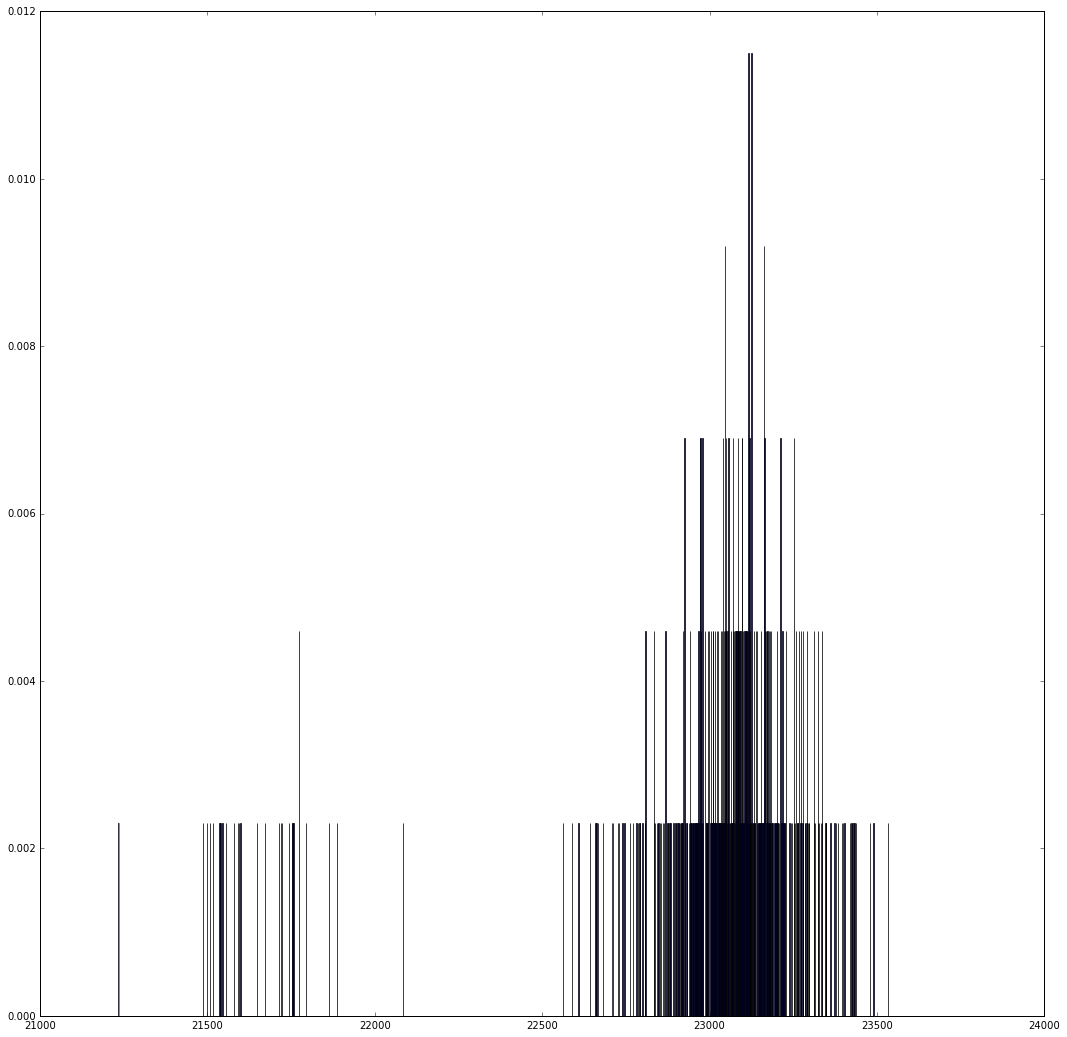

In [17]:
[reps2, vals, obsVals, ect, maxct, minct, rangect, pvalueRange, pvalueChi2] =\
    summarizeSams(uniqueSamplesRU.values(), n, k, verbose=True)

ns, bins, patches = plt.hist(uniqueSamplesRU.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (18.0, 18.0) 

Randu with PIKK hits all 435 samples, but not equally often. Based on the chi-square test and the range test, the $p$-value for the hypothesis that these $10^7$ samples are simple random samples is essentially 0.

Now let's see what this heterogeneity might do to an estimator.

In [18]:
# least frequent samples
minFreq = np.argmin(uniqueSamplesRU.values())
print uniqueSamplesRU.values()[minFreq], uniqueSamplesRU.keys()[minFreq]

x = [0]*n
i = 0
for k in uniqueSamplesRU.keys()[minFreq]: # set extremes to +/-1
    x[k]= (-1)**i
    i = i+1
print x

21235 frozenset([26, 27])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0]


Let's repeat the experiment using MT instead of RANDU.

In [19]:
# Mersenne Twister
mtg = Random(1234567890) # set seed of MT

n=30
k=2
reps = int(10**7)

uniqueSamplesMT = tallySamples(n, k, mtg, reps)

reps: 10000000 possible values: 435.0 observed values: 435 expected count: 22988.5057471 min count: 22481 max count: 23589 range: 1108 p value for range: 0.0150883950552 p value for chi-square: Power_divergenceResult(statistic=444.42900499999996, pvalue=0.35428665071021709)


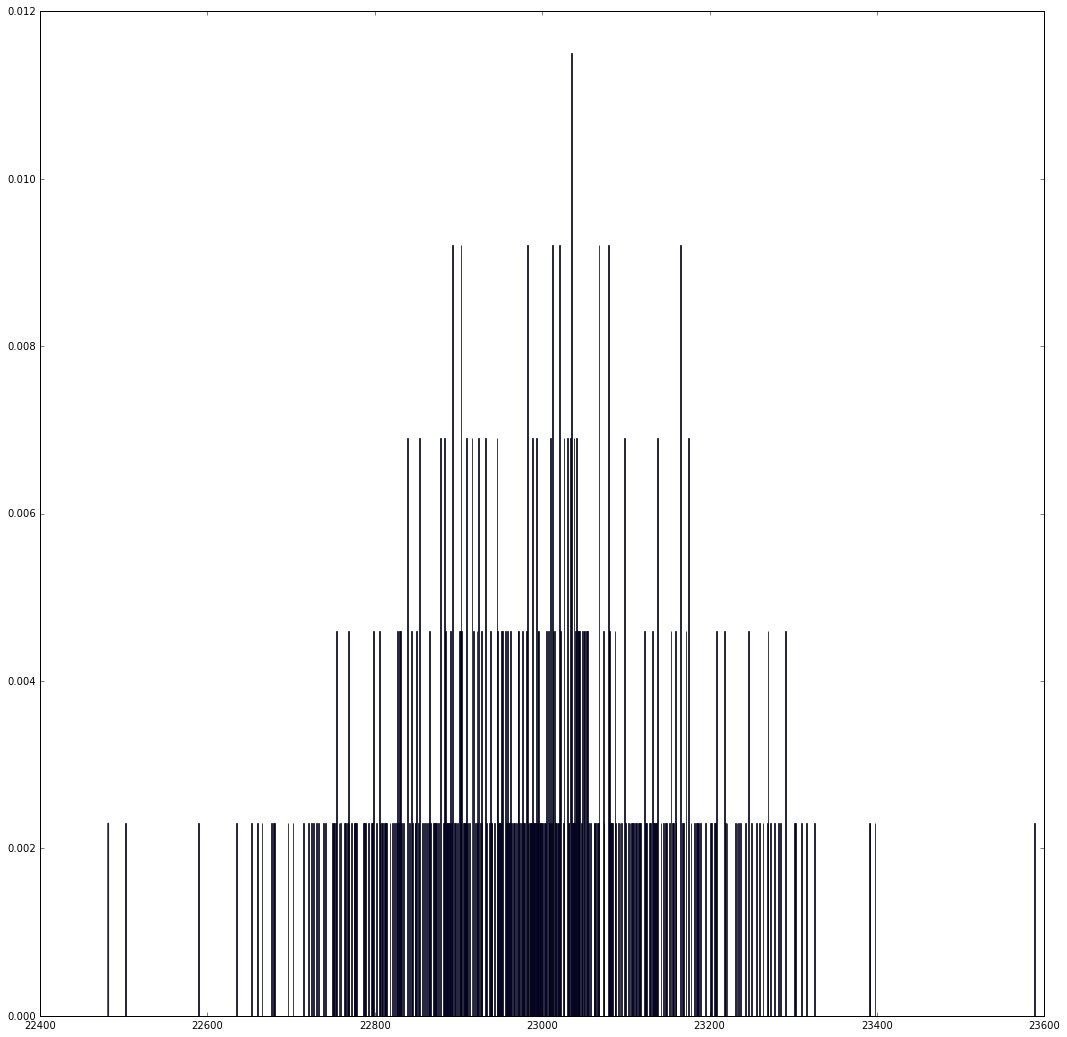

In [20]:
[reps2, vals, obsVals, ect, maxct, minct, rangect, pvalueRange, pvalueChi2] =\
    summarizeSams(uniqueSamplesMT.values(), n, k, verbose=True)

ns, bins, patches = plt.hist(uniqueSamplesMT.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (18.0, 18.0) 

In [21]:
minFreq = np.argmin(uniqueSamplesMT.values())
print uniqueSamplesMT.values()[minFreq], uniqueSamplesMT.keys()[minFreq]

x = [0]*n
i = 0
for k in uniqueSamplesMT.keys()[minFreq]: # set extremes to +/-1
    x[k]= (-1)**i
    i = i+1
    
print x

22481 frozenset([3, 22])
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]


### Bias in the sample variance, $k=2$

$s^2 = \frac{1}{n-1} \sum_{j=1}^n (x_j - \bar{x})^2$

For sample size $n=2$, $s^2 = (x_1 - \bar{x})^2 + (x_2 - \bar{x})^2$.

Use MT sample

In [22]:
# distribution of sample variance:  
# 
# 1 + 1 = 2  with probability 1/(30C2)
# 2*(1/2)^2 = 1/2 with probability 2C1*28C1/(30C2)
# 0 with probability 28C2/(30C2)

eVar = (2 + 0.5*2*28 + 0*14*27)/vals

seVar = math.sqrt(((2-eVar)**2 + 2*28*(1/2-eVar)**2 + 14*27*(0-eVar)**2)/vals)

seMeanVar = seVar/math.sqrt(reps)

samVar = aveSamVar(uniqueSamplesMT)

diff = samVar-eVar
print reps, vals, '\n', eVar, samVar, diff, seVar, seMeanVar, diff/eVar, diff/seMeanVar 

10000000 435.0 
0.0689655172414 0.06885465 -0.000110867241379 0.1913715438 6.05169957751e-05 -0.001607575 -1.83200173702


The sample variance is biased downwards by 1.83SE.

### Default sampling algorithm in Python

In [23]:
# New tally function for np.random.choice()

def tallyPySamples(n, k, reps=int(10**7)):
    uniqueSampleCounts = dict()
    for i in xrange(reps):
        sam = frozenset(np.sort((np.random.choice(n, size=k, replace=False))))
        if sam in uniqueSampleCounts:
            uniqueSampleCounts[sam] += 1
        else:
            uniqueSampleCounts[sam] = 1
    return uniqueSampleCounts

np.random.seed(1234567890) # set seed of MT

n=30
k=2
reps = int(10**8)

uniqueSamplesPy = tallyPySamples(n, k, reps)

reps: 100000000 possible values: 435.0 observed values: 435 expected count: 229885.057471 min count: 228510 max count: 231441 range: 2931 p value for range: 0.373829851965 p value for chi-square: Power_divergenceResult(statistic=474.14538710000005, pvalue=0.089280242281253766)


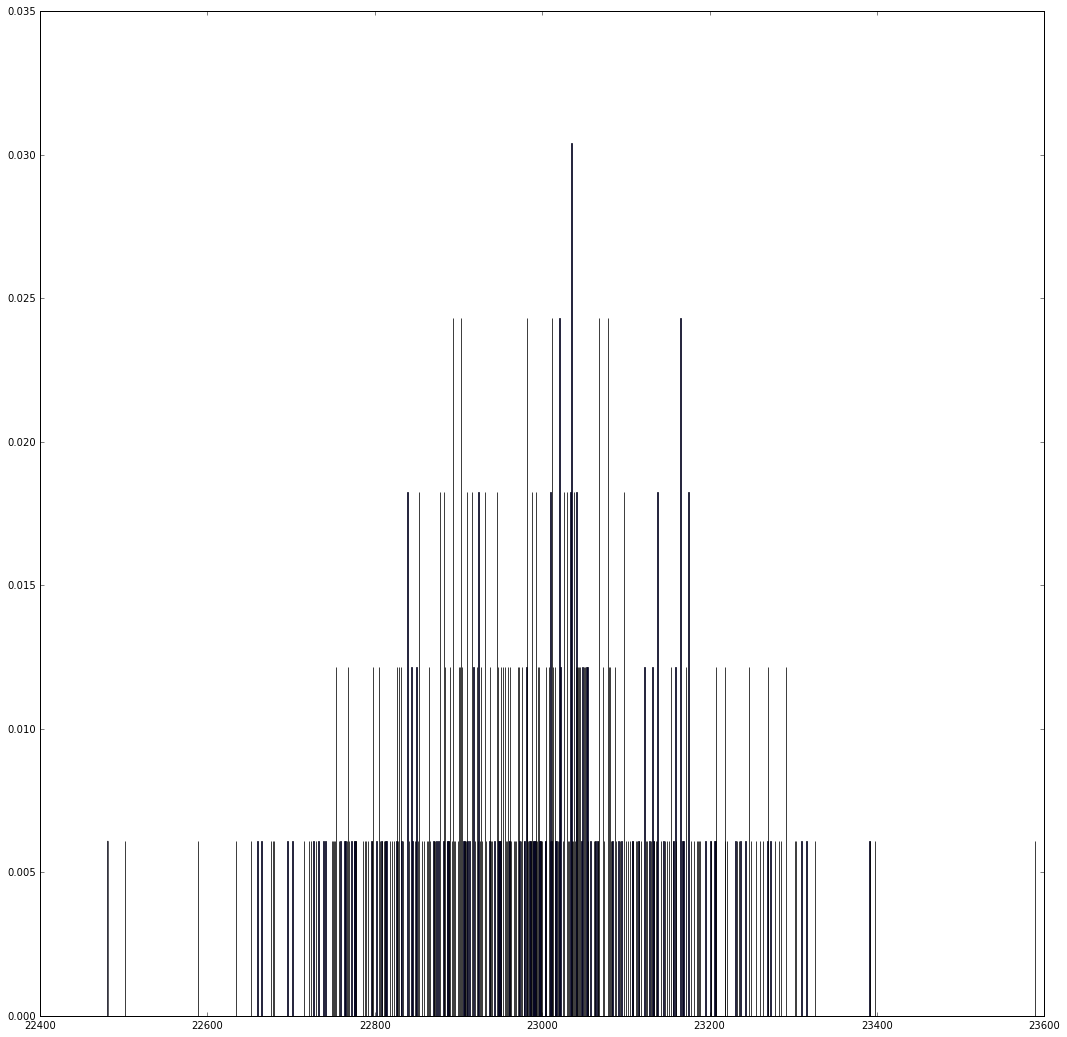

In [24]:
[reps2, vals, obsVals, ect, maxct, minct, rangect, pvalueRange, pvalueChi2] =\
    summarizeSams(uniqueSamplesPy.values(), n, k, verbose=True)


ns, bins, patches = plt.hist(uniqueSamplesMT.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (18.0, 18.0) 


In [25]:
minFreq = np.argmin(uniqueSamplesPy.values())
print uniqueSamplesPy.values()[minFreq], uniqueSamplesPy.keys()[minFreq]

x = [0]*n
i = 0
for k in uniqueSamplesPy.keys()[minFreq]: # set extremes to +/-1
    x[k]= (-1)**i
    i = i+1
print x

228510 frozenset([16, 1])
[0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [33]:
# distribution of sample variance:  
# 
# 1 + 1 = 2  with probability 1/(30C2)
# 2*(1/2)^2 = 1/2 with probability 2C1*28C1/(30C2)
# 0 with probability 28C2/(30C2)

eVar = (2 + 0.5*2*28 + 0*14*27)/vals

seVar = math.sqrt(((2-eVar)**2 + 2*28*(1/2-eVar)**2 + 14*27*(0-eVar)**2)/vals)

seMeanVar = seVar/math.sqrt(reps)

samVar = aveSamVar(uniqueSamplesPy)

diff = samVar-eVar
print reps, vals, '\n', eVar, samVar, diff, seVar, seMeanVar, diff/eVar, diff/seMeanVar 

0.0689655172414 100000000 435.0 
0.0689655172414 0.068930595 -3.49222413793e-05 0.1913715438 1.913715438e-05 -0.0005063725 -1.82483982132


## Hypothesis tests for various PRNGS

$5 \times 10^7$ replications, $n=30$, $k=2$.

Sample variance of a population
with 28 zeros, one 1, one -1.

In [29]:
import pandas as pd
pd.set_option('display.float_format', '{:.4g}'.format)

In [39]:
US = pd.read_csv('uniqueSampleSummary.csv')
US_cols = ['PRNG', 'seed', 'Chi-squared', 'Df', 'P-value', 'Range', 'Range P-value']
US[US_cols].sort_values(['Range P-value', 'P-value'])

,PRNG,seed,Chi-squared,Df,P-value,Range,Range P-value
0,RANDU,100,[ 12155.0519878],434,[ 0.],8709,-4.441e-16
9,MT_choice,100,[ 407.4165142],434,[ 0.81558425],2286,0.08578
6,SHA256,100,[ 409.6081138],434,[ 0.79423828],2196,0.171
1,SD,100,[ 355.2852094],434,[ 0.99767171],2189,0.1798
3,MT,100,[ 454.6745488],434,[ 0.23778712],2174,0.1996
5,MT,429496729,[ 493.676701],434,[ 0.02488693],2089,0.341
10,MT_choice,233424280,[ 461.0437666],434,[ 0.17825415],2026,0.4741
4,MT,233424280,[ 429.9387088],434,[ 0.54602838],1965,0.6143
8,SHA256,429496729,[ 482.0878312],434,[ 0.05502463],1964,0.6166
7,SHA256,233424280,[ 381.5704324],434,[ 0.96666455],1846,0.8545


In [48]:
biases = pd.read_csv('statBias.csv')
biases_lfs = biases[biases['method']=='least freq sample']
cols = ['PRNG', 'seed', 'Avg Sample Var', 'Var Bias', 'Var Bias/SE']
biases[cols].sort_values(['Var Bias/SE', 'PRNG', 'seed'], ascending = True)

,PRNG,seed,Avg Sample Var,Var Bias,Var Bias/SE
1,RANDU,100,0.06879,-0.0001749,-6.462
19,MT_choice,100,0.06888,-8.172e-05,-3.019
13,SHA256,100,0.0689,-6.341e-05,-2.343
15,SHA256,233424280,0.06892,-4.549e-05,-1.681
3,SD,100,0.06892,-4.337e-05,-1.602
7,MT,100,0.06892,-4.176e-05,-1.543
23,MT_choice,429496729,0.06893,-3.774e-05,-1.394
9,MT,233424280,0.06893,-3.407e-05,-1.259
5,SD,233424280,0.06894,-2.605e-05,-0.9624
21,MT_choice,233424280,0.06895,-2.036e-05,-0.7522


## PRNGs in Common packages

| Package/Lang   | default    | other      | SRS algorithm  |
|:---------------|:----------:|:----------:|:--------------:|
| SAS 9.2        | MT         | 32-bit LCG |                |
| SPSS 20.0      | 32-bit LCG | MT1997ar   |                |
| SPSS &le; 12.0 | 32-bit LCG |            |                |
| STATA 13       | KISS 32    |            |                |
| STATA 14       | MT         |            |                |
| R              | MT         |            | trunc          |
| python         | MT         |            | mask           |
| MATLAB         | MT         |            |                ||

**Key.** MT = Mersenne Twister. LCG = linear congruential generator. ANS = "assign a number to each of the $n$ items and sort." The KISS generator combines 4 generators of three types: two multiply-with-carry
generators, the 3-shift register SHR3 and the congruential generator CONG.

Prior to April 2011, in Stata 10 exhibited predictable behavior:
95.1% of the $2^{31}$ possible seed values resulted in the first and second draws from rnormal() having the same sign.

## Best Practices

+ Use a source of real randomness to set the seed with a substantial amount of entropy, e.g., 20 rolls of 10-sided dice.
+ Record the seed so your analysis is reproducible.
+ Use a PRNG at least as good as the Mersenne Twister, and preferably a cryptographic quality PRNG. Consider the PCG family. Avoid standard linear congruential generators and the Wichmann-Hill generator.
+ Use open-source software, and record the version of the software you use.
+ Use a sampling algorithm that does not "waste randomness." Avoid permuting the entire population.
+ Be aware of discretization issues in the sampling algorithm; many methods assume the PRNG produces $U[0,1]$ or $U[0,1)$ random numbers, rather than (an approximation to) numbers that are uniform on $w$-bit binary integers.
+ Consider the size of the problem: are your PRNG and sampling algorithm adequate?
+ Avoid "tests of representativeness" and procedures that reject some samples. They alter the distribution of the sample.

## Recommendations

+ Replace the standard PRNGs in R and Python with PRNGs with unbounded state spaces, and cryptographic or near-cryptographic quality
    - Consider using AES in counter mode, since Intel chips have hardware support for AES
+ Replace R's sample() with the mask algorithm

### To do

+ tests that rely on the permutation, not just the sample, e.g., Spearman. Asymptotic distribution known.
+ examples where choice() breaks
+ R examples where sample() breaks, for $ n < \approx 2^{25}$
+ implement SHA-256 plug-in replacement; test. Does it pass? Timing tests, too.
+ extend the test suites using the things we've found, e.g., range statistic for multinomial hits using PIKK.


In [27]:
%load_ext version_information
%version_information scipy, numpy, pandas, matplotlib, notebook

//anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:809: FormatterWarning: JSON expects JSONable list/dict containers, not JSON strings
  FormatterWarning)


Software versions
Python 2.7.11 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 5.1.0
OS Darwin 16.1.0 x86_64 i386 64bit
scipy 0.18.1
numpy 1.11.2
pandas 0.19.0
matplotlib 1.5.0
notebook 4.2.3
Sat Oct 22 00:33:59 2016 PDT

In [44]:
# %load talktools.py
"""Tools to style a talk."""

from IPython.display import HTML, display, YouTubeVideo

def prefix(url):
    prefix = '' if url.startswith('http') else 'http://'
    return prefix + url


def simple_link(url, name=None):
    name = url if name is None else name
    url = prefix(url)
    return '<a href="%s" target="_blank">%s</a>' % (url, name)


def html_link(url, name=None):
    return HTML(simple_link(url, name))


# Utility functions
def website(url, name=None, width=800, height=450):
    html = []
    if name:
        html.extend(['<div class="nb_link">',
                     simple_link(url, name),
                     '</div>'] )

    html.append('<iframe src="%s"  width="%s" height="%s">' %
                (prefix(url), width, height))
    return HTML('\n'.join(html))


def nbviewer(url, name=None, width=800, height=450):
    return website('nbviewer.ipython.org/url/' + url, name, width, height)

# Load and publish CSS
style = HTML(open('talkStyle.css').read())

display(style)